# Predicting telemarketing success in the banking sector: the case of Portuguese bank (Part II)

Alexander Kalita

# Introduction

The initial phase of the Portuguese bank deposit project focused on Machine Learning (ML) model development [1]. This phase involved crucial steps such as data cleaning, feature engineering, model training, and interpretation.

However, the true value of the ML model lies in its practical implementation, which requires the adoption of Machine Learning Operations (MLOps) principles. This part of the project covers the development and staging environments.

The project offers a solution for predicting future bank deposit subscriptions resulting from a marketing campaign conducted by the Portuguese bank. The ML model is presented through a simple and interactive application named Depositer.

Depositer addresses a common challenge faced by deposit marketers: the inefficient allocation of marketing budgets towards targeting customers unlikely to subscribe to term deposits. By accurately identifying the desired customer group, it optimizes telemarketing campaigns and enhances budget efficiency.

In conclusion, the project demonstrates the importance of integrating Data and ML algorithms for tangible business outcomes.

# Project architecture

The MLOps architecture of the Depositer application consists of two main parts. The first part focuses solely on data exploration and analysis, detailed in a separate file [1]. The second part, which is the focus of this project, encompasses all other components of the pipeline. Each aspect of the Depositer MLOps pipeline is discussed below.

The project pipeline begins with the upload of the dataset and exploratory data analysis conducted in JupyterLab, where the XGBoost model emerges as the best-trained model. This initial phase constitutes the first part of the project.

Subsequently, the trained XGBoost model undergoes version control using Git, and various experiments are conducted with MLflow in a Pipenv virtual environment. The model is locally tested using a Flask server, and important feature reliability tests, such as explanations with SHAP values and bias feature assessment, are carried out. Additionally, the model is showcased in a local environment using a Streamlit UI to demonstrate the Depositer application.

In the pre-production stage, the focus shifts to deploying the model in a production-ready environment. This involves deploying the model with Gunicorn and Streamlit, followed by thorough integration testing. Both the server and client are containerized using Docker, pushed to an online container repository on Docker Hub, and connected using Docker Compose.

The overall architecture is presented below.

In [2]:
# Display MLOps pipeline architecture
from IPython.display import IFrame
diagram_path = 'C:/Users/Alexander_Kalita/Desktop/My_Projects/2_Bank_Marketing/2_MLOps/4_Architecture/Depositer_MLOps_dev_staging.svg'
IFrame(diagram_path, width=1100, height=600)

# Model development

This section is dedicated to model development, a crucial step aimed at ensuring the reproducibility of model results.

Git is an essential tool for version control, facilitating efficient management of the entire project.

In [ ]:
# Initialize Git repository
cd "C:\Users\Alexander_Kalita\my_mlops_project"
git init
git add .
git commit -m "Initial commit"
git ls-files
    
git add .gitignore
git commit -m "Add .gitignore to ignore sensitive files"

A Pipenv environment has been created to isolate and manage the dependencies of Python projects.

In [ ]:
# Create pipenv environment
cd "C:\Users\Alexander_Kalita\my_mlops_project"
pipenv install
pipenv shell
pipenv --python 3.8

The MLflow server is a pivotal tool for streamlining model experimentation. It has been installed to support this process.

In [ ]:
# Install MLflow server
pipenv install mlflow
pipenv shell
mlflow server --host 127.0.0.1 --port 8080

The XGBoost model, previously utilized in the initial part of the project, undergoes retraining [1].

In [7]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import mlflow
import warnings
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.stats import yeojohnson
from mlflow.sklearn import log_model
from mlflow.models import infer_signature
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Load dataset
bank_data = pd.read_csv('C:/Users/Alexander_Kalita/my_mlops_project/data/bank-full.csv', sep=",")
bank_data.head()

# View data structure
print(bank_data.info())

# Change object into category type variables
for col in bank_data.select_dtypes(include='object').columns:
    bank_data[col] = bank_data [col].astype('category')
print(bank_data.dtypes)

# Separate the features and the target variable
X = bank_data.drop('y', axis=1)
y = bank_data['y']

# Transform numeric variables using the Yeo-Johnson transformation
num_cols = bank_data.select_dtypes(include=['int64']).columns
transformed_data = pd.DataFrame()
for col in num_cols:
    transformed_data[col] = yeojohnson(bank_data[col])[0]
bank_data.drop(columns=num_cols, inplace=True)
display(transformed_data.head())

# Transform categorical variables into binary variables
cat_vars = ['job', 'education', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
binary_data = pd.get_dummies(bank_data[cat_vars], columns=cat_vars, drop_first=True)
bank_data.drop(columns=cat_vars, inplace=True)
bank_data['y'] = bank_data['y'].map({'no': 0, 'yes': 1})
X = pd.concat([bank_data, binary_data], axis=1)
y = bank_data['y']
display(X.head())

# Combine the transformed numerical and categorical variables into a single dataset
final_data = pd.concat([transformed_data, binary_data, bank_data['y']], axis=1)
X = final_data.drop(columns=['y'])
y = final_data['y']
final_data.info()

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('Training data shape:', X_train.shape, y_train.shape)
print('Testing data shape:', X_test.shape, y_test.shape)

# Create a DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost hyperparameters
params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 5,
    'colsample_bytree': 0.8
}

# Build the XGBoost model with 5-fold cross-validation
xgb_cv = XGBClassifier(**params)
xgb_cv.fit(X_train, y_train)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_cv, X, y, cv=kf)
print("Cross-validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Evaluate the model on the test set
threshold = 0.2
y_test_pred_prob = xgb_cv.predict_proba(X_test)[:,1]
y_test_pred = np.where(y_test_pred_prob >= threshold, 1, 0)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Threshold:', threshold)
print('Test Accuracy:', test_accuracy)

# Ignore warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost.data')

# Save and load the trained XGBoost model
xgb_cv.save_model("xgb_cv.json")
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None
age             int64
job          category
marital      category
education    category
defaul

,age,balance,day,duration,campaign,pdays,previous
0,2.828869,733.541036,3.551032,8.284871,0.487299,-1.949658,-0.0
1,2.701662,19.404127,3.551032,7.175362,0.487299,-1.949658,-0.0
2,2.562883,1.802083,3.551032,5.898797,0.487299,-1.949658,-0.0
3,2.732573,545.749528,3.551032,6.241565,0.487299,-1.949658,-0.0
4,2.562883,0.939543,3.551032,7.714252,0.487299,-1.949658,-0.0


,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,0,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,0,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
3,0,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
4,0,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  45211 non-null  float64 
 1   balance              45211 non-null  float64 
 2   day                  45211 non-null  float64 
 3   duration             45211 non-null  float64 
 4   campaign             45211 non-null  float64 
 5   pdays                45211 non-null  float64 
 6   previous             45211 non-null  float64 
 7   job_blue-collar      45211 non-null  bool    
 8   job_entrepreneur     45211 non-null  bool    
 9   job_housemaid        45211 non-null  bool    
 10  job_management       45211 non-null  bool    
 11  job_retired          45211 non-null  bool    
 12  job_self-employed    45211 non-null  bool    
 13  job_services         45211 non-null  bool    
 14  job_student          45211 non-null  bool    
 15  job_technician     

The trained XGBoost machine learning model has been saved as a Python file to facilitate automation in subsequent processes.

In [8]:
# Save train.py file
code = """
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import mlflow
import warnings
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.stats import yeojohnson
from mlflow.sklearn import log_model
from mlflow.models import infer_signature
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Load dataset
bank_data = pd.read_csv('C:/Users/Alexander_Kalita/my_mlops_project/data/bank-full.csv', sep=",")
bank_data.head()

# View data structure
print(bank_data.info())

# Change object into category type variables
for col in bank_data.select_dtypes(include='object').columns:
    bank_data[col] = bank_data [col].astype('category')
print(bank_data.dtypes)

# Separate the features and the target variable
X = bank_data.drop('y', axis=1)
y = bank_data['y']

# Transform numeric variables using the Yeo-Johnson transformation
num_cols = bank_data.select_dtypes(include=['int64']).columns
transformed_data = pd.DataFrame()
for col in num_cols:
    transformed_data[col] = yeojohnson(bank_data[col])[0]
bank_data.drop(columns=num_cols, inplace=True)
display(transformed_data.head())

# Transform categorical variables into binary variables
cat_vars = ['job', 'education', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
binary_data = pd.get_dummies(bank_data[cat_vars], columns=cat_vars, drop_first=True)
bank_data.drop(columns=cat_vars, inplace=True)
bank_data['y'] = bank_data['y'].map({'no': 0, 'yes': 1})
X = pd.concat([bank_data, binary_data], axis=1)
y = bank_data['y']
display(X.head())

# Combine the transformed numerical and categorical variables into a single dataset
final_data = pd.concat([transformed_data, binary_data, bank_data['y']], axis=1)
X = final_data.drop(columns=['y'])
y = final_data['y']
final_data.info()

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('Training data shape:', X_train.shape, y_train.shape)
print('Testing data shape:', X_test.shape, y_test.shape)

# Create a DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost hyperparameters
params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'n_estimators': 100,
    'max_depth': 5,
    'colsample_bytree': 0.8
}

# Build the XGBoost model with 5-fold cross-validation
xgb_cv = XGBClassifier(**params)
xgb_cv.fit(X_train, y_train)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_cv, X, y, cv=kf)
print("Cross-validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Evaluate the model on the test set
threshold = 0.2
y_test_pred_prob = xgb_cv.predict_proba(X_test)[:,1]
y_test_pred = np.where(y_test_pred_prob >= threshold, 1, 0)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Threshold:', threshold)
print('Test Accuracy:', test_accuracy)

# Ignore warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost.data')

# Save and load the trained XGBoost model
xgb_cv.save_model("xgb_cv.json")
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")
"""
with open('train.py', 'w') as file:
    file.write(code)
print('Code saved to train.py')

Code saved to train.py


The XGBoost model version is logged using MLflow, preserving its configuration for future reference and reproducibility.

In [12]:
# Log XGBoost model with MLflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("MLflow XGBoost model")
with mlflow.start_run():
    mlflow.log_params(params)
    mlflow.log_metric("accuracy", test_accuracy)
    mlflow.set_tag("Training Info", "XGBoost model for bank deposit data")
    signature = infer_signature(X_train, xgb_cv.predict(X_train))
    model_info = mlflow.sklearn.log_model(
        sk_model=xgb_cv,
        artifact_path="xgboost_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-xgboost",
    )

2024/07/24 13:47:23 INFO mlflow.tracking.fluent: Experiment with name 'MLflow XGBOOST model' does not exist. Creating a new experiment.
Successfully registered model 'tracking-xgboost'.
2024/07/24 13:47:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-xgboost, version 1
Created version '1' of model 'tracking-xgboost'.


# Model deployment

The Model Deployment section is a pivotal component of the project, focusing on the rigorous testing of the ML model before its seamless transition into a production environment.

## Local environment testing

The local environment subsection is crucial for testing and validating various aspects of the application within controlled settings. This phase involves several critical tasks to ensure the robustness, functionality, and reliability of the ML components.

All essential packages required for this section have been initialized.

In [7]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import shap
import json
import joblib
import logging
import requests
import unittest
import xgboost as xgb
import streamlit as st
from flask import Flask, request, jsonify

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


The Flask API server is an optimal choice for this project, offering a lightweight and straightforward solution for facilitating machine learning predictions with the XGBoost model. It efficiently handles incoming requests and provides predictions with the expected functionality in the local environment.

In [57]:
# Create Flask application
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")
expected_number_of_features = 42
def predict_single(features, model):
    feature_names = model.get_booster().feature_names
    features = [features.get(feature, 0) for feature in feature_names]
    X = np.array(features).reshape(1, -1)
    prediction = loaded_model.predict_proba(X)
    return float(prediction[0, 1])
application = Flask('banksubscriptions')
@application.route('/predict', methods=['POST','GET'])
def predict():
    try:
        if request.method == 'POST':
            data = request.get_json(force=True)
            print(request.method)
            features = data.get('features', {})
        else:
            features = request.args.get('features')
            features = json.loads(features) if features else {}
        if len(features) != expected_number_of_features:
            return jsonify({'error': 'Invalid number of features'}), 400
        prediction = predict_single(features, loaded_model)
        return jsonify({'prediction': prediction})
    except Exception as e:
        return jsonify({'error': str(e)}), 500
if __name__ == '__main__':
    application.run(host='0.0.0.0', port=8081)

 * Serving Flask app 'banksubscriptions'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8081
 * Running on http://192.168.1.5:8081
Press CTRL+C to quit


The Flask server has been saved as a Python file to support automation in subsequent stages.

In [18]:
# Save app.py file
code = """
import json
import numpy as np
import xgboost as xgb
from flask import Flask, request, jsonify

# Create Flask application
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")
expected_number_of_features = 42
def predict_single(features, model):
    feature_names = model.get_booster().feature_names
    features = [features.get(feature, 0) for feature in feature_names]
    X = np.array(features).reshape(1, -1)
    prediction = loaded_model.predict_proba(X)
    return float(prediction[0, 1])
application = Flask(__name__)
@application.route('/predict', methods=['POST','GET'])
def predict():
    try:
        if request.method == 'POST':
            data = request.get_json(force=True)
            features = data.get('features', {})
        else:
            features = request.args.get('features')
            features = json.loads(features) if features else {}
        if len(features) != expected_number_of_features:
            return jsonify({'error': 'Invalid number of features'}), 400
        prediction = predict_single(features, loaded_model)
        return jsonify({'prediction': prediction})
    except Exception as e:
        return jsonify({'error': str(e)}), 500
if __name__ == '__main__':
    application.run(host='0.0.0.0', port=8081)
"""
with open('app.py', 'w') as file:
    file.write(code)
print('Code saved to app.py')

Code saved to app.py


Flask has been tested within the virtual Pipenv environment to ensure compatibility and resolve any dependency issues. The server ran as expected without any problems.

In [ ]:
# Create flask virtual pipenv environment
pipenv install flask --dev
pipenv shell
cd C:/Users/Alexander_Kalita/my_mlops_project/flask
python app.py

The prediction test indicates a customer deposit subscription probability of 75.2% based on the current features.

In [61]:
# Predict new customer deposit subscription
customer = {
    'features': {
        'age': 18,
        'balance': 300,
        'day': 5,
        'duration': 500,
        'campaign': 1,
        'pdays': -1,
        'previous': 4,
        'job_blue-collar': 0,
        'job_entrepreneur': 0,
        'job_housemaid': 0,
        'job_management': 1,
        'job_retired': 0,
        'job_self-employed': 0,
        'job_services': 0,
        'job_student': 0,
        'job_technician': 0,
        'job_unemployed': 0,
        'job_unknown': 0,
        'education_secondary': 1,
        'education_tertiary': 0,
        'education_unknown': 0,
        'marital_married': 0,
        'marital_single': 1,
        'default_yes': 1,
        'housing_yes': 1,
        'loan_yes': 1,
        'contact_telephone': 1,
        'contact_unknown': 0,
        'month_aug': 0,
        'month_dec': 0,
        'month_feb': 0,
        'month_jan': 0,
        'month_jul': 1,
        'month_jun': 0,
        'month_mar': 0,
        'month_may': 0,
        'month_nov': 0,
        'month_oct': 0,
        'month_sep': 0,
        'poutcome_other': 0,
        'poutcome_success': 1,
        'poutcome_unknown': 0
    }
}
url = "http://localhost:8081/predict"
headers = {'Content-Type': 'application/json'}
response = requests.post(url, json=customer, headers=headers)
prediction = response.json()['prediction']
print('Deposit Subscription Probability:', prediction)

Deposit Subscription Probability: 0.7520260214805603


Calculating SHAP (SHapley Additive exPlanations) values is essential, especially in industries like finance, where clear explanations of feature impacts on the model's results are crucial. This helps in understanding the model and meets strict standards for explaining and supporting model predictions.

In [39]:
# Provide SHAP values prediction explanations
customer = {
    'features': {
        'age': 18,
        'balance': 300,
        'day': 5,
        'duration': 500,
        'campaign': 1,
        'pdays': -1,
        'previous': 4,
        'job_blue-collar': 0,
        'job_entrepreneur': 0,
        'job_housemaid': 0,
        'job_management': 1,
        'job_retired': 0,
        'job_self-employed': 0,
        'job_services': 0,
        'job_student': 0,
        'job_technician': 0,
        'job_unemployed': 0,
        'job_unknown': 0,
        'education_secondary': 1,
        'education_tertiary': 0,
        'education_unknown': 0,
        'marital_married': 0,
        'marital_single': 1,
        'default_yes': 1,
        'housing_yes': 1,
        'loan_yes': 1,
        'contact_telephone': 1,
        'contact_unknown': 0,
        'month_aug': 0,
        'month_dec': 0,
        'month_feb': 0,
        'month_jan': 0,
        'month_jul': 1,
        'month_jun': 0,
        'month_mar': 0,
        'month_may': 0,
        'month_nov': 0,
        'month_oct': 0,
        'month_sep': 0,
        'poutcome_other': 0,
        'poutcome_success': 1,
        'poutcome_unknown': 0
    }
}
features_dict = customer['features']
features_df = pd.DataFrame([features_dict])
explainer = shap.Explainer(loaded_model)
shap_values = explainer.shap_values(features_df)
feature_names = features_df.columns
for i, sample_shap_values in enumerate(shap_values):
    print(f"SHAP values:")
    for feature_name, shap_value in zip(feature_names, sample_shap_values):
        print(f"{feature_name}: {shap_value}")

SHAP values:
age: 0.4085119366645813
balance: 0.00936928205192089
day: -0.16958069801330566
duration: 2.1908700466156006
campaign: -0.3290681540966034
pdays: 0.010121178813278675
previous: 0.15919622778892517
job_blue-collar: 0.003963420167565346
job_entrepreneur: 0.0015646042302250862
job_housemaid: 0.0031551136635243893
job_management: 0.0010431224945932627
job_retired: 0.0007066776161082089
job_self-employed: 0.0013353931717574596
job_services: -0.00048360609798692167
job_student: -0.0005459800595417619
job_technician: 0.010327431373298168
job_unemployed: -0.0009735506027936935
job_unknown: 0.0016866660444065928
education_secondary: 0.040435001254081726
education_tertiary: -0.020960604771971703
education_unknown: 0.0030642857309430838
marital_married: 0.04536732658743858
marital_single: -0.002526066731661558
default_yes: 0.12318313121795654
housing_yes: -0.07928973436355591
loan_yes: -0.14557774364948273
contact_telephone: -0.06903877854347229
contact_unknown: 0.14817702770233154
mo

[14:49:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


The visualization plot below illustrates the most impactful features based on SHAP values.

Positive SHAP values are notably associated with factors such as call duration, previous successful campaign outcomes, and client age. Consequently, bank deposit subscribers are more likely to be older clients with longer call durations and prior positive experiences with the bank's marketing campaigns.

Negative SHAP values highlight features such as a higher number of contacts during the current campaign, contact day, the summer month of July, and having a personal loan, which significantly decrease the likelihood of customer subscription.

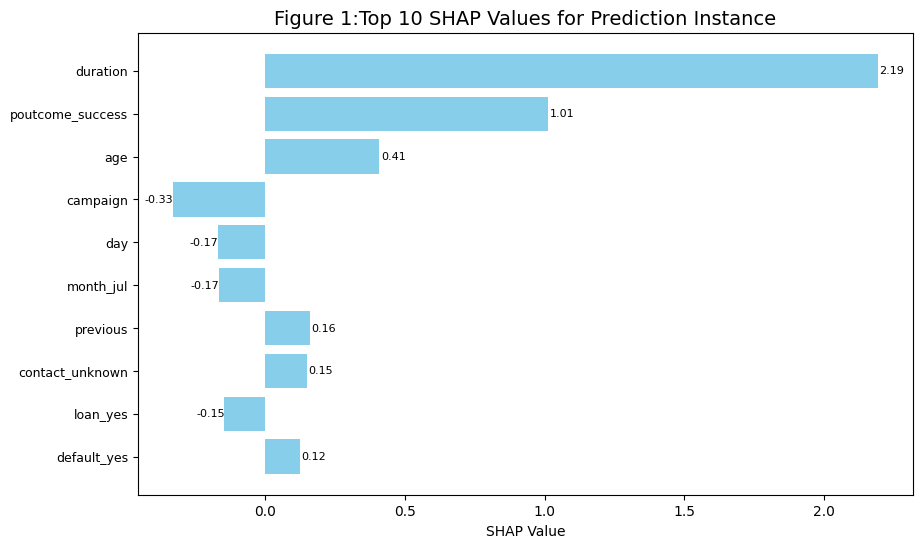

In [38]:
# Create SHAP values visualization plot
shap_values_instance = shap_values[0]
abs_shap_values = np.abs(shap_values_instance)
sorted_indices = np.argsort(abs_shap_values)
top_features_indices = sorted_indices[-10:][::-1]
top_shap_values = shap_values_instance[top_features_indices]
top_feature_names = [feature_names[i] for i in top_features_indices]
plt.figure(figsize=(10, 6))
bars = plt.barh(top_feature_names, top_shap_values, color="skyblue")
for bar, shap_value in zip(bars, top_shap_values):
    if shap_value < 0:
        plt.text(bar.get_x() + bar.get_width() - 0.05, bar.get_y() + bar.get_height() / 2, f'{shap_value:.2f}',
                 ha='center', va='center', fontsize=8)
    else:
        plt.text(bar.get_x() + bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2, f'{shap_value:.2f}',
                 ha='center', va='center', fontsize=8)
plt.xlabel("SHAP Value")
plt.yticks(fontsize=9)
plt.title("Figure 1:Top 10 SHAP Values for Prediction Instance", fontsize=14)
plt.gca().invert_yaxis()
plt.show()

Both SHAP values and their corresponding visualization plot has been saved in Python file.

In [40]:
# Save shap_explanations.py file
code = """
import shap
import json
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Load XGBOOST model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

# Provide SHAP values prediction explanations
customer = {
    'features': {
        'age': 18,
        'balance': 300,
        'day': 5,
        'duration': 500,
        'campaign': 1,
        'pdays': -1,
        'previous': 4,
        'job_blue-collar': 0,
        'job_entrepreneur': 0,
        'job_housemaid': 0,
        'job_management': 1,
        'job_retired': 0,
        'job_self-employed': 0,
        'job_services': 0,
        'job_student': 0,
        'job_technician': 0,
        'job_unemployed': 0,
        'job_unknown': 0,
        'education_secondary': 1,
        'education_tertiary': 0,
        'education_unknown': 0,
        'marital_married': 0,
        'marital_single': 1,
        'default_yes': 1,
        'housing_yes': 1,
        'loan_yes': 1,
        'contact_telephone': 1,
        'contact_unknown': 0,
        'month_aug': 0,
        'month_dec': 0,
        'month_feb': 0,
        'month_jan': 0,
        'month_jul': 1,
        'month_jun': 0,
        'month_mar': 0,
        'month_may': 0,
        'month_nov': 0,
        'month_oct': 0,
        'month_sep': 0,
        'poutcome_other': 0,
        'poutcome_success': 1,
        'poutcome_unknown': 0
    }
}
features_dict = customer['features']
features_df = pd.DataFrame([features_dict])
explainer = shap.Explainer(loaded_model)
shap_values = explainer.shap_values(features_df)
feature_names = features_df.columns
for i, sample_shap_values in enumerate(shap_values):
    print(f"SHAP values:")
    for feature_name, shap_value in zip(feature_names, sample_shap_values):
        print(f"{feature_name}: {shap_value}")

# Create SHAP values visualization plot
shap_values_instance = shap_values[0]
abs_shap_values = np.abs(shap_values_instance)
sorted_indices = np.argsort(abs_shap_values)
top_features_indices = sorted_indices[-10:][::-1]
top_shap_values = shap_values_instance[top_features_indices]
top_feature_names = [feature_names[i] for i in top_features_indices]
plt.figure(figsize=(10, 6))
bars = plt.barh(top_feature_names, top_shap_values, color="skyblue")
for bar, shap_value in zip(bars, top_shap_values):
    if shap_value < 0:
        plt.text(bar.get_x() + bar.get_width() - 0.05, bar.get_y() + bar.get_height() / 2, f'{shap_value:.2f}',
                 ha='center', va='center', fontsize=8)
    else:
        plt.text(bar.get_x() + bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2, f'{shap_value:.2f}',
                 ha='center', va='center', fontsize=8)
plt.xlabel("SHAP Value")
plt.yticks(fontsize=9)
plt.title("Figure 1:Top 10 SHAP Values for Prediction Instance", fontsize=14)
plt.gca().invert_yaxis()
plt.show()
"""
with open('shap_explanations.py', 'w') as file:
    file.write(code)
print('Code saved to shap_explanations.py')

Code saved to shap_explanations.py


Evaluating whether a feature introduces bias in model predictions is crucial. This assessment has been conducted using the Disparate Impact Ratio (DIR), which aligns with the "four-fifths rule" established by the U.S. Equal Employment Opportunity Commission (EEOC).

Ideally, the DIR should be equal to one, indicating equal proportions for all groups. According to the "four-fifths rule," any DIR value below 80% may suggest "evidence of adverse impact."

Given that DIR is a fraction and the denominator may exceed the numerator, the acceptable DIR range is considered to be between 80% and 120%. For more details, refer to [4].

In this project, all sensitive variables fall within the acceptable DIR range of 0.8 to 1. It is important to note that this test applies to binary and categorical variables, excluding numeric features like age.

In [41]:
# Conduct Bias assessment for each sensitive feature
sensitive_features = ['job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 
'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_secondary', 'education_tertiary', 'education_unknown', 'marital_married',
'marital_single']
def calculate_disparate_impact(y_true, y_pred):
    non_sensitive_indices = ~y_true.astype(bool)
    positive_proportion_sensitive = y_pred.mean()
    positive_proportion_non_sensitive = y_pred[non_sensitive_indices].mean()
    if positive_proportion_sensitive == 0:
        return float('nan')
    disparate_impact = positive_proportion_non_sensitive / positive_proportion_sensitive
    return disparate_impact
for sensitive_feature in sensitive_features:
    y_true_sensitive = X_test[sensitive_feature].astype(float)
    y_pred_sensitive = y_test_pred
    disparate_impact = calculate_disparate_impact(y_true_sensitive, y_pred_sensitive)
    print(f"Disparate Impact Ratio for {sensitive_feature}: {disparate_impact}")

Disparate Impact Ratio for job_blue-collar: 1.1009374615656087
Disparate Impact Ratio for job_entrepreneur: 1.0075925362113747
Disparate Impact Ratio for job_housemaid: 1.0039878946663987
Disparate Impact Ratio for job_management: 0.9603016827951932
Disparate Impact Ratio for job_retired: 0.9352061432309978
Disparate Impact Ratio for job_self-employed: 0.9983608879824595
Disparate Impact Ratio for job_services: 1.02602072483231
Disparate Impact Ratio for job_student: 0.9703227968968453
Disparate Impact Ratio for job_technician: 1.0145022246546065
Disparate Impact Ratio for job_unemployed: 0.9935373021395573
Disparate Impact Ratio for job_unknown: 0.9996288209392018
Disparate Impact Ratio for education_secondary: 1.1089361574268015
Disparate Impact Ratio for education_tertiary: 0.9030301151867772
Disparate Impact Ratio for education_unknown: 0.9849862934117605
Disparate Impact Ratio for marital_married: 1.1579462719062659
Disparate Impact Ratio for marital_single: 0.9083573808415037


The bias assessment has been saved as a Python file.

In [42]:
# Save bias_assessment.py file
code = """
import json
import numpy as np
import xgboost as xgb

# Load XGBOOST model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

# Conduct Bias assessment for each sensitive feature
sensitive_features = ['job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 
'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'education_secondary', 'education_tertiary', 'education_unknown', 'marital_married',
'marital_single']

def calculate_disparate_impact(y_true, y_pred):
    non_sensitive_indices = ~y_true.astype(bool)
    positive_proportion_sensitive = y_pred.mean()
    positive_proportion_non_sensitive = y_pred[non_sensitive_indices].mean()
    if positive_proportion_sensitive == 0:
        return float('nan')
    disparate_impact = positive_proportion_non_sensitive / positive_proportion_sensitive
    return disparate_impact

for sensitive_feature in sensitive_features:
    y_true_sensitive = X_test[sensitive_feature].astype(float)
    y_pred_sensitive = y_test_pred
    disparate_impact = calculate_disparate_impact(y_true_sensitive, y_pred_sensitive)
    print(f"Disparate Impact Ratio for {sensitive_feature}: {disparate_impact}")
"""
with open('bias_assessment.py', 'w') as file:
    file.write(code)
print('Code saved to bias_assessment.py')

Code saved to bias_assessment.py


Unit tests are essential for systematically assessing different components of the application in isolation. This proactive approach helps detect potential issues before the application advances to production.

The unit test results indicate that all components are functioning as expected. 

In [55]:
# Conduct unit testing
def predict(features, model):
    prediction = model.predict(np.array([list(features.values())]))
    binary_prediction = np.round(prediction)
    return int(binary_prediction[0])
class TestModel(unittest.TestCase):
    def test_predict(self):
        features = {
            'age': 18,
            'balance': 300,
            'day': 5,
            'duration': 500,
            'campaign': 1,
            'pdays': -1,
            'previous': 4,
            'job_blue-collar': 0,
            'job_entrepreneur': 0,
            'job_housemaid': 0,
            'job_management': 1,
            'job_retired': 0,
            'job_self-employed': 0,
            'job_services': 0,
            'job_student': 0,
            'job_technician': 0,
            'job_unemployed': 0,
            'job_unknown': 0,
            'education_secondary': 1,
            'education_tertiary': 0,
            'education_unknown': 0,
            'marital_married': 1,
            'marital_single': 0,
            'default_yes': 0,
            'housing_yes': 1,
            'loan_yes': 0,
            'contact_telephone': 1,
            'contact_unknown': 0,
            'month_aug': 0,
            'month_dec': 0,
            'month_feb': 0,
            'month_jan': 0,
            'month_jul': 1,
            'month_jun': 0,
            'month_mar': 0,
            'month_may': 0,
            'month_nov': 0,
            'month_oct': 0,
            'month_sep': 0,
            'poutcome_other': 0,
            'poutcome_success': 0,
            'poutcome_unknown': 1
        }
        prediction = predict(features, loaded_model)
        self.assertIn(prediction, [0, 1])
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestModel))

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

The Python file containing the unit tests has been saved.

In [44]:
# Save unit_testing.py file
code = """
import json
import unittest
import numpy as np
import xgboost as xgb

# Load XGBOOST model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

# Conduct unit testing
def predict(features, model):
    prediction = model.predict(np.array([list(features.values())]))
    binary_prediction = np.round(prediction)
    return int(binary_prediction[0])

class TestModel(unittest.TestCase):
    def test_predict(self):
        features = {
            'age': 18,
            'balance': 300,
            'day': 5,
            'duration': 500,
            'campaign': 1,
            'pdays': -1,
            'previous': 4,
            'job_blue-collar': 0,
            'job_entrepreneur': 0,
            'job_housemaid': 0,
            'job_management': 1,
            'job_retired': 0,
            'job_self-employed': 0,
            'job_services': 0,
            'job_student': 0,
            'job_technician': 0,
            'job_unemployed': 0,
            'job_unknown': 0,
            'education_secondary': 1,
            'education_tertiary': 0,
            'education_unknown': 0,
            'marital_married': 1,
            'marital_single': 0,
            'default_yes': 0,
            'housing_yes': 1,
            'loan_yes': 0,
            'contact_telephone': 1,
            'contact_unknown': 0,
            'month_aug': 0,
            'month_dec': 0,
            'month_feb': 0,
            'month_jan': 0,
            'month_jul': 1,
            'month_jun': 0,
            'month_mar': 0,
            'month_may': 0,
            'month_nov': 0,
            'month_oct': 0,
            'month_sep': 0,
            'poutcome_other': 0,
            'poutcome_success': 0,
            'poutcome_unknown': 1
        }
        prediction = predict(features, loaded_model)
        self.assertIn(prediction, [0, 1])

unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestModel))
"""
with open('unit_testing.py', 'w') as file:
    file.write(code)
print('Code saved to unit_testing.py')

Code saved to unit_testing.py


An end-to-end test of the ML project has been successfully completed. This comprehensive test evaluates the application as a unified entity, ensuring that all components work seamlessly together. 

The results were error-free, demonstrating the robustness and coherence of the entire application.

In [59]:
# Conduct end-to-end-test
class TestEndToEnd(unittest.TestCase):
    def test_end_to_end(self):
        features = {
            'age': 18,
            'balance': 300,
            'day': 5,
            'duration': 500,
            'campaign': 1,
            'pdays': -1,
            'previous': 4,
            'job_blue-collar': 0,
            'job_entrepreneur': 0,
            'job_housemaid': 0,
            'job_management': 1,
            'job_retired': 0,
            'job_self-employed': 0,
            'job_services': 0,
            'job_student': 0,
            'job_technician': 0,
            'job_unemployed': 0,
            'job_unknown': 0,
            'education_secondary': 1,
            'education_tertiary': 0,
            'education_unknown': 0,
            'marital_married': 1,
            'marital_single': 0,
            'default_yes': 0,
            'housing_yes': 1,
            'loan_yes': 0,
            'contact_telephone': 1,
            'contact_unknown': 0,
            'month_aug': 0,
            'month_dec': 0,
            'month_feb': 0,
            'month_jan': 0,
            'month_jul': 1,
            'month_jun': 0,
            'month_mar': 0,
            'month_may': 0,
            'month_nov': 0,
            'month_oct': 0,
            'month_sep': 0,
            'poutcome_other': 0,
            'poutcome_success': 0,
            'poutcome_unknown': 1
        }
        endpoint = "http://localhost:8081/predict"
        response = requests.post(endpoint, json={'features': features})
        self.assertEqual(response.status_code, 200)
        print("Response content:", response.content)
        response_json = response.json()
        print("Response JSON:", response_json)
        prediction = response_json.get('prediction', None)
        self.assertIsNotNone(prediction)
        self.assertGreaterEqual(prediction, 0.0)
        self.assertLessEqual(prediction, 1.0)
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestEndToEnd))

.
----------------------------------------------------------------------
Ran 1 test in 2.064s

OK


Response content: b'{"prediction":0.6571007966995239}\n'
Response JSON: {'prediction': 0.6571007966995239}


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

A Python file for performing end-to-end tests has been saved.

In [74]:
# Save end_to_end_test.py file
code = """
import json
import unittest
import requests
import numpy as np
import xgboost as xgb

# Load XGBOOST model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

# Conduct end-to-end-test
class TestEndToEnd(unittest.TestCase):
    def test_end_to_end(self):
        features = {
            'age': 18,
            'balance': 300,
            'day': 5,
            'duration': 500,
            'campaign': 1,
            'pdays': -1,
            'previous': 4,
            'job_blue-collar': 0,
            'job_entrepreneur': 0,
            'job_housemaid': 0,
            'job_management': 1,
            'job_retired': 0,
            'job_self-employed': 0,
            'job_services': 0,
            'job_student': 0,
            'job_technician': 0,
            'job_unemployed': 0,
            'job_unknown': 0,
            'education_secondary': 1,
            'education_tertiary': 0,
            'education_unknown': 0,
            'marital_married': 1,
            'marital_single': 0,
            'default_yes': 0,
            'housing_yes': 1,
            'loan_yes': 0,
            'contact_telephone': 1,
            'contact_unknown': 0,
            'month_aug': 0,
            'month_dec': 0,
            'month_feb': 0,
            'month_jan': 0,
            'month_jul': 1,
            'month_jun': 0,
            'month_mar': 0,
            'month_may': 0,
            'month_nov': 0,
            'month_oct': 0,
            'month_sep': 0,
            'poutcome_other': 0,
            'poutcome_success': 0,
            'poutcome_unknown': 1
        }
        endpoint = "http://localhost:8081/predict"
        response = requests.post(endpoint, json={'features': features})
        self.assertEqual(response.status_code, 200)
        print("Response content:", response.content)
        response_json = response.json()
        print("Response JSON:", response_json)
        prediction = response_json.get('prediction', None)
        self.assertIsNotNone(prediction)
        self.assertGreaterEqual(prediction, 0.0)
        self.assertLessEqual(prediction, 1.0)  
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestEndToEnd))
"""
with open('end_to_end_test.py', 'w') as file:
    file.write(code)
print('Code saved to end_to_end_test.py')

Code saved to end_to_end_test.py


The decision to showcase the Depositer application using Streamlit was driven by its simplicity and seamless integration with Python, which simplifies the configuration process.

Depositer has undergone thorough testing within the local terminal environment. It demonstrates reliable functionality and meets expectations for smooth operation.

In [68]:
# Create Depositer application in Streamlit
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

st.title('Depositer')
st.write("Predict deposit subscriptions")

def user_input_features():
    age = st.slider('Age (in years)', 18, 130, 18)
    balance = st.slider('Balance (in EUR)', -10000000, 10000000, 0)
    day = st.slider('Last Contact Day of the Month', 1, 31, 1)
    duration = st.slider('Duration of Last Contact (in seconds)', 0, 10000, 0)
    campaign = st.slider('Number of Contacts Performed During This Campaign', 1, 1000, 1)
    pdays = st.slider('Number of Days Passed After the Client Was Last Contacted (-1 means not previously contacted)', -1, 1000, -1)
    previous = st.slider('Number of Contacts Performed Before This Campaign', 0, 1000, 0)

    job = ['Blue-Collar', 'Entrepreneur', 'Housemaid', 'Management', 'Retired', 'Self-employed',
           'Services', 'Student', 'Technician', 'Unemployed', 'Unknown']
    job_selected = st.selectbox("Job Type", job)
    job_category = {f'job_{category.lower()}': 1 if category == job_selected else 0 for category in job}
    
    education = ['Secondary', 'Tertiary', 'Unknown']
    education_selected = st.selectbox("Education Level", education)
    education_category = {f'education_{category.lower()}': 1 if category == education_selected else 0 for category in education}

    marital = ['Married', 'Single']
    marital_selected = st.selectbox("Marital Status", marital)
    marital_category = {f'marital_{category.lower()}': 1 if category == marital_selected else 0 for category in marital}

    contact =  ['Telephone', 'Unknown']
    contact_selected = st.selectbox("Contact Communication Type", contact)
    contact_category = {f'contact_{category.lower()}': 1 if category == contact_selected else 0 for category in contact}

    month = ['January', 'February', 'March', 'May', 'June', 'July', 'August','September', 'October', 'November', 'December']
    month_selected = st.selectbox('Contact Month', month)
    month_category = {f'month_{category.lower()}': 1 if category == month_selected else 0 for category in month}
    
    poutcome = ['Success', 'Other', 'Unknown']
    poutcome_selected = st.selectbox('Previous Campaign Outcome', poutcome)
    poutcome_category = {f'poutcome_{category.lower()}': 1 if category == poutcome_selected else 0 for category in poutcome}

    default_yes = st.checkbox('Credit Default (Yes)')
    housing_yes = st.checkbox('Housing Loan (Yes)')
    loan_yes = st.checkbox('Personal Loan (Yes)')
    
    user_features = {
        'age': age,
        'balance': balance,
        'day': day,
        'duration': duration,
        'campaign': campaign,
        'pdays': pdays,
        'previous': previous,
        'job_blue-collar': job_category,
        'job_entrepreneur': job_category,
        'job_housemaid': job_category,
        'job_management': job_category,
        'job_retired': job_category,
        'job_self-employed': job_category,
        'job_services': job_category,
        'job_student': job_category,
        'job_technician': job_category,
        'job_unemployed': job_category,
        'job_unknown': job_category,
        'education_secondary': education_category,
        'education_tertiary': education_category,
        'education_unknown': education_category,
        'marital_married': marital_category,
        'marital_single': marital_category,
        'contact_telephone': contact_category,
        'contact_unknown': contact_category,
        'month_aug': month_category,
        'month_dec': month_category,
        'month_feb': month_category,
        'month_jan': month_category,
        'month_jul': month_category,
        'month_jun': month_category,
        'month_mar': month_category,
        'month_may': month_category,
        'month_nov': month_category,
        'month_oct': month_category,
        'month_sep': month_category,
        'poutcome_other': poutcome_category,
        'poutcome_success': poutcome_category,
        'poutcome_unknown': poutcome_category,
        'default_yes': default_yes,
        'housing_yes': housing_yes,
        'loan_yes': loan_yes
    }
    return user_features

user_features = user_input_features()
if st.button('Predict'):
    flattened_features = {}
    for key, value in user_features.items():
        if isinstance(value, dict):
            flattened_features.update(value)
        else:
            flattened_features[key] = value
    url = "http://localhost:8081/predict"
    headers = {'Content-Type': 'application/json'}
    response = requests.post(url, json={'features': flattened_features}, headers=headers)
    if response and response.status_code == 200:
        prediction = response.json().get('prediction', None)
        st.success(f'Deposit Subscription Probability: {prediction:.2f}')
    elif response:
        st.error("Failed to get prediction from the server.")

Streamlit application has been saved in a Python file.

In [67]:
# Save streamlit_app.py file
code = """
import json
import requests
import xgboost as xgb
import streamlit as st

# Create Depositer application in Streamlit
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

st.title('Depositer')
st.write("Predict deposit subscriptions")

def user_input_features():
    age = st.slider('Age (in years)', 18, 130, 18)
    balance = st.slider('Balance (in EUR)', -10000000, 10000000, 0)
    day = st.slider('Last Contact Day of the Month', 1, 31, 1)
    duration = st.slider('Duration of Last Contact (in seconds)', 0, 10000, 0)
    campaign = st.slider('Number of Contacts Performed During This Campaign', 1, 1000, 1)
    pdays = st.slider('Number of Days Passed After the Client Was Last Contacted (-1 means not previously contacted)', -1, 1000, -1)
    previous = st.slider('Number of Contacts Performed Before This Campaign', 0, 1000, 0)

    job = ['Blue-Collar', 'Entrepreneur', 'Housemaid', 'Management', 'Retired', 'Self-employed',
           'Services', 'Student', 'Technician', 'Unemployed', 'Unknown']
    job_selected = st.selectbox("Job Type", job)
    job_category = {f'job_{category.lower()}': 1 if category == job_selected else 0 for category in job}
    
    education = ['Secondary', 'Tertiary', 'Unknown']
    education_selected = st.selectbox("Education Level", education)
    education_category = {f'education_{category.lower()}': 1 if category == education_selected else 0 for category in education}

    marital = ['Married', 'Single']
    marital_selected = st.selectbox("Marital Status", marital)
    marital_category = {f'marital_{category.lower()}': 1 if category == marital_selected else 0 for category in marital}

    contact =  ['Telephone', 'Unknown']
    contact_selected = st.selectbox("Contact Communication Type", contact)
    contact_category = {f'contact_{category.lower()}': 1 if category == contact_selected else 0 for category in contact}

    month = ['January', 'February', 'March', 'May', 'June', 'July', 'August','September', 'October', 'November', 'December']
    month_selected = st.selectbox('Contact Month', month)
    month_category = {f'month_{category.lower()}': 1 if category == month_selected else 0 for category in month}
    
    poutcome = ['Success', 'Other', 'Unknown']
    poutcome_selected = st.selectbox('Previous Campaign Outcome', poutcome)
    poutcome_category = {f'poutcome_{category.lower()}': 1 if category == poutcome_selected else 0 for category in poutcome}

    default_yes = st.checkbox('Credit Default (Yes)')
    housing_yes = st.checkbox('Housing Loan (Yes)')
    loan_yes = st.checkbox('Personal Loan (Yes)')
    
    user_features = {
        'age': age,
        'balance': balance,
        'day': day,
        'duration': duration,
        'campaign': campaign,
        'pdays': pdays,
        'previous': previous,
        'job_blue-collar': job_category,
        'job_entrepreneur': job_category,
        'job_housemaid': job_category,
        'job_management': job_category,
        'job_retired': job_category,
        'job_self-employed': job_category,
        'job_services': job_category,
        'job_student': job_category,
        'job_technician': job_category,
        'job_unemployed': job_category,
        'job_unknown': job_category,
        'education_secondary': education_category,
        'education_tertiary': education_category,
        'education_unknown': education_category,
        'marital_married': marital_category,
        'marital_single': marital_category,
        'contact_telephone': contact_category,
        'contact_unknown': contact_category,
        'month_aug': month_category,
        'month_dec': month_category,
        'month_feb': month_category,
        'month_jan': month_category,
        'month_jul': month_category,
        'month_jun': month_category,
        'month_mar': month_category,
        'month_may': month_category,
        'month_nov': month_category,
        'month_oct': month_category,
        'month_sep': month_category,
        'poutcome_other': poutcome_category,
        'poutcome_success': poutcome_category,
        'poutcome_unknown': poutcome_category,
        'default_yes': default_yes,
        'housing_yes': housing_yes,
        'loan_yes': loan_yes
    }
    return user_features

user_features = user_input_features()
if st.button('Predict'):
    flattened_features = {}
    for key, value in user_features.items():
        if isinstance(value, dict):
            flattened_features.update(value)
        else:
            flattened_features[key] = value
    url = "http://localhost:8081/predict"
    headers = {'Content-Type': 'application/json'}
    response = requests.post(url, json={'features': flattened_features}, headers=headers)
    if response and response.status_code == 200:
        prediction = response.json().get('prediction', None)
        st.success(f'Deposit Subscription Probability: {prediction:.2f}')
    elif response:
        st.error("Failed to get prediction from the server.")
"""
with open('streamlit_app.py', 'w') as file:
    file.write(code)
print('Code saved to streamlit_app.py')

Code saved to streamlit_app.py


Streamlit has been tested in a virtual Pipenv environment to mitigate potential dependency conflicts. It ran smoothly without any issues.

In [ ]:
# Create streamlit virtual pipenv environment
pipenv install streamlit
pipenv shell
cd C:/Users/Alexander_Kalita/my_mlops_project/streamlit_app
streamlit run streamlit_app.py

The demo video below showcases the local testing of the Depositer app using the Flask server and Streamlit client. It demonstrates the application's speed and efficiency in operation.

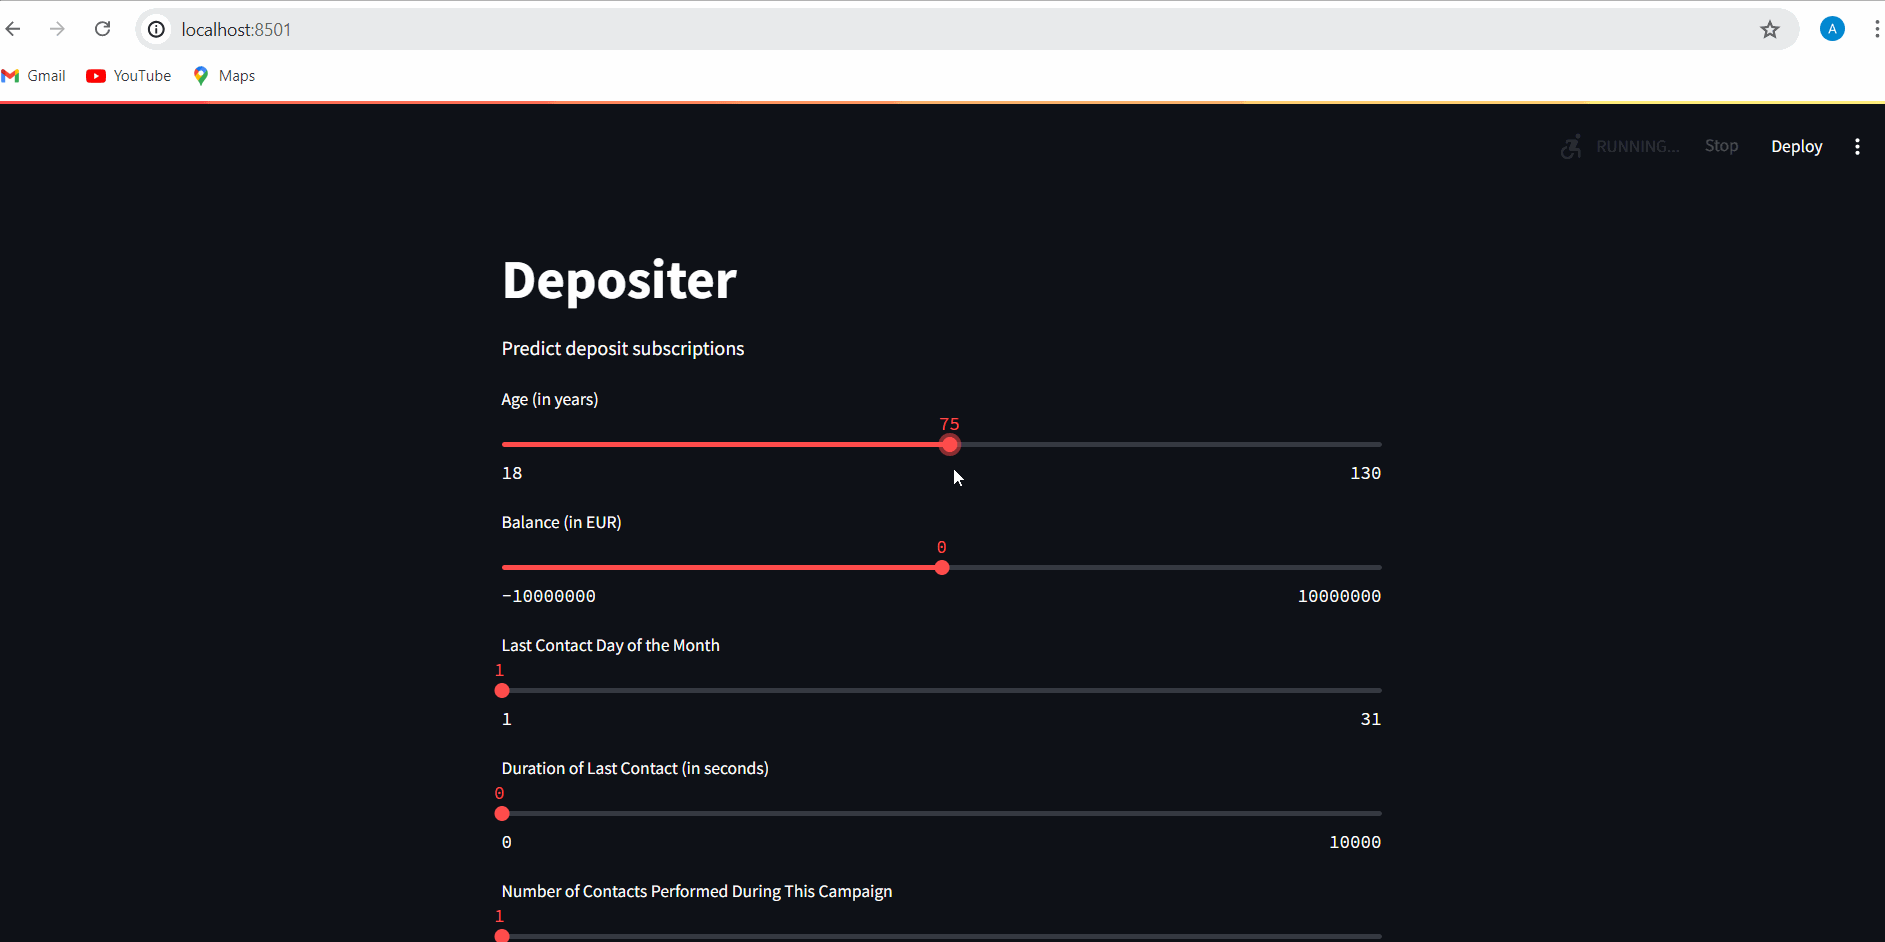

In [73]:
from IPython.display import Image, display
gif_path = 'C:/Users/Alexander_Kalita/Desktop/My_Projects/2_Portuguese_bank/2_MLOps/depositer_dev.gif'
display(Image(filename=gif_path))

## Staging environment

The project progresses to the staging environment, a pre-production setup designed for comprehensive testing before deployment to the live production environment. This phase focuses on ensuring that both server and client components are thoroughly tested and containerized to function optimally in production settings.

In the previous phase, the Flask server was tested locally and performed adequately. However, for production, it lacked the robustness needed to handle the diverse challenges of a live environment. To address this, the Gunicorn server, an advanced extension of Flask, has been deployed via a Python file to enhance reliability.

In [3]:
# Save gunicorn_app.py file
code = """
import json
import numpy as np
import xgboost as xgb
from flask import Flask, request, jsonify

# Create Gunicorn application
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

expected_number_of_features = 42

def predict_single(features, model):
    feature_names = model.get_booster().feature_names
    features = [features.get(feature, 0) for feature in feature_names]
    X = np.array(features).reshape(1, -1)
    prediction = model.predict_proba(X)
    return float(prediction[0, 1])

application = Flask(__name__)

@application.route('/predict', methods=['POST', 'GET'])
def predict():
    try:
        if request.method == 'POST':
            data = request.get_json(force=True)
            features = data.get('features', {})
        else:
            features = request.args.get('features')
            features = json.loads(features) if features else {}
        if len(features) != expected_number_of_features:
            return jsonify({'error': 'Invalid number of features'}), 400
        prediction = predict_single(features, loaded_model)
        return jsonify({'prediction': prediction})
    except Exception as e:
        return jsonify({'error': str(e)}), 500
"""
with open('gunicorn_app.py', 'w') as file:
    file.write(code)
print('Code saved to gunicorn_app.py')

Code saved to gunicorn_app.py


The Streamlit application, previously tested locally, required only configuring the prediction URL to interact with the Gunicorn API server. This adjustment enables Streamlit to obtain machine learning predictions.

In [4]:
# Save streamlit_app.py file
code = """
import json
import requests
import xgboost as xgb
import streamlit as st

# Create Depositer application in Streamlit
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_cv.json")

st.title('Depositer')
st.write("Predict deposit subscriptions")

def user_input_features():
    age = st.slider('Age (in years)', 18, 130, 18)
    balance = st.slider('Balance (in EUR)', -10000000, 10000000, 0)
    day = st.slider('Last Contact Day of the Month', 1, 31, 1)
    duration = st.slider('Duration of Last Contact (in seconds)', 0, 10000, 0)
    campaign = st.slider('Number of Contacts Performed During This Campaign', 1, 1000, 1)
    pdays = st.slider('Number of Days Passed After the Client Was Last Contacted (-1 means not previously contacted)', -1, 1000, -1)
    previous = st.slider('Number of Contacts Performed Before This Campaign', 0, 1000, 0)

    job = ['Blue-Collar', 'Entrepreneur', 'Housemaid', 'Management', 'Retired', 'Self-employed',
           'Services', 'Student', 'Technician', 'Unemployed', 'Unknown']
    job_selected = st.selectbox("Job Type", job)
    job_category = {f'job_{category.lower()}': 1 if category == job_selected else 0 for category in job}
    
    education = ['Secondary', 'Tertiary', 'Unknown']
    education_selected = st.selectbox("Education Level", education)
    education_category = {f'education_{category.lower()}': 1 if category == education_selected else 0 for category in education}

    marital = ['Married', 'Single']
    marital_selected = st.selectbox("Marital Status", marital)
    marital_category = {f'marital_{category.lower()}': 1 if category == marital_selected else 0 for category in marital}

    contact =  ['Telephone', 'Unknown']
    contact_selected = st.selectbox("Contact Communication Type", contact)
    contact_category = {f'contact_{category.lower()}': 1 if category == contact_selected else 0 for category in contact}

    month = ['January', 'February', 'March', 'May', 'June', 'July', 'August','September', 'October', 'November', 'December']
    month_selected = st.selectbox('Contact Month', month)
    month_category = {f'month_{category.lower()}': 1 if category == month_selected else 0 for category in month}
    
    poutcome = ['Success', 'Other', 'Unknown']
    poutcome_selected = st.selectbox('Previous Campaign Outcome', poutcome)
    poutcome_category = {f'poutcome_{category.lower()}': 1 if category == poutcome_selected else 0 for category in poutcome}

    default_yes = st.checkbox('Credit Default (Yes)')
    housing_yes = st.checkbox('Housing Loan (Yes)')
    loan_yes = st.checkbox('Personal Loan (Yes)')
    
    user_features = {
        'age': age,
        'balance': balance,
        'day': day,
        'duration': duration,
        'campaign': campaign,
        'pdays': pdays,
        'previous': previous,
        'job_blue-collar': job_category,
        'job_entrepreneur': job_category,
        'job_housemaid': job_category,
        'job_management': job_category,
        'job_retired': job_category,
        'job_self-employed': job_category,
        'job_services': job_category,
        'job_student': job_category,
        'job_technician': job_category,
        'job_unemployed': job_category,
        'job_unknown': job_category,
        'education_secondary': education_category,
        'education_tertiary': education_category,
        'education_unknown': education_category,
        'marital_married': marital_category,
        'marital_single': marital_category,
        'contact_telephone': contact_category,
        'contact_unknown': contact_category,
        'month_aug': month_category,
        'month_dec': month_category,
        'month_feb': month_category,
        'month_jan': month_category,
        'month_jul': month_category,
        'month_jun': month_category,
        'month_mar': month_category,
        'month_may': month_category,
        'month_nov': month_category,
        'month_oct': month_category,
        'month_sep': month_category,
        'poutcome_other': poutcome_category,
        'poutcome_success': poutcome_category,
        'poutcome_unknown': poutcome_category,
        'default_yes': default_yes,
        'housing_yes': housing_yes,
        'loan_yes': loan_yes
    }
    return user_features

user_features = user_input_features()
if st.button('Predict'):
    flattened_features = {}
    for key, value in user_features.items():
        if isinstance(value, dict):
            flattened_features.update(value)
        else:
            flattened_features[key] = value
    url = "http://gunicorn-app:8081/predict"
    headers = {'Content-Type': 'application/json'}
    response = requests.post(url, json={'features': flattened_features}, headers=headers)
    if response and response.status_code == 200:
        prediction = response.json().get('prediction', None)
        st.success(f'Deposit Subscription Probability: {prediction:.2f}')
    elif response:
        st.error("Failed to get prediction from the server.")
"""
with open('streamlit_app.py', 'w') as file:
    file.write(code)
print('Code saved to streamlit_app.py')

Code saved to streamlit_app.py


Docker, a modern containerization tool, manages and isolates the server and client applications' environments effectively.

The Dockerfile for the Gunicorn API server has been created using a text editor.

In [ ]:
# Create Dockerfile for gunicorn_app
FROM python:3.8-slim
WORKDIR /app
COPY gunicorn_app.py /app
COPY xgb_cv.json /app
COPY requirements.txt /app
RUN pip install --no-cache-dir -r requirements.txt
EXPOSE 8081
CMD ["gunicorn", "-w", "4", "-b", "0.0.0.0:8081", "gunicorn_app:application"]

A Docker container has been set up for the Gunicorn API to ensure isolated dependencies.

In [ ]:
# Create gunicorn docker container
cd C:\Users\Alexander_Kalita\my_mlops_project\gunicorn
docker build -t xgb_cv_image .
docker run -it --name xgb_cv_container -p 8081:8081 xgb_cv_image

Similarly, the Dockerfile for the Streamlit application has been configured using a text editor.

In [ ]:
# Create Dockerfile for streamlit app
FROM python:3.8-slim
WORKDIR /app
COPY streamlit_app /app
RUN pip install --no-cache-dir -r requirements.txt
CMD ["streamlit", "run", "streamlit_app.py"]

The Streamlit application has been successfully containerized.

In [ ]:
# Create streamlit docker container
cd C:\Users\Alexander_Kalita\my_mlops_project\streamlit_app
docker build -t xgb_cv_streamlit_image .
docker run -it --name xgb_cv_streamlit_container -p 8501:8501 xgb_cv_streamlit_image

Integration testing has been conducted to verify compatibility between the Gunicorn API server and the Streamlit app, with successful results.

In [22]:
# Conduct integration test
class TestIntegration(unittest.TestCase):
    def test_model_integration(self):
        features = {
            'age': 18,
            'balance': 300,
            'day': 5,
            'duration': 500,
            'campaign': 1,
            'pdays': -1,
            'previous': 4,
            'job_blue-collar': 0,
            'job_entrepreneur': 0,
            'job_housemaid': 0,
            'job_management': 1,
            'job_retired': 0,
            'job_self-employed': 0,
            'job_services': 0,
            'job_student': 0,
            'job_technician': 0,
            'job_unemployed': 0,
            'job_unknown': 0,
            'education_secondary': 1,
            'education_tertiary': 0,
            'education_unknown': 0,
            'marital_married': 1,
            'marital_single': 0,
            'default_yes': 0,
            'housing_yes': 1,
            'loan_yes': 0,
            'contact_telephone': 1,
            'contact_unknown': 0,
            'month_aug': 0,
            'month_dec': 0,
            'month_feb': 0,
            'month_jan': 0,
            'month_jul': 1,
            'month_jun': 0,
            'month_mar': 0,
            'month_may': 0,
            'month_nov': 0,
            'month_oct': 0,
            'month_sep': 0,
            'poutcome_other': 0,
            'poutcome_success': 0,
            'poutcome_unknown': 1
        }
        endpoint = "http://localhost:8081/predict"
        response = requests.post(endpoint, json={'features': features})
        self.assertEqual(response.status_code, 200)
        response_json = response.json()
        prediction = response_json.get('prediction', None)
        self.assertIsNotNone(prediction)
        self.assertGreaterEqual(prediction, 0.0)
        self.assertLessEqual(prediction, 1.0)
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestIntegration))

.
----------------------------------------------------------------------
Ran 1 test in 0.033s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

The integration test has been saved as a Python file for future reference.

In [23]:
# Save integration_test.py file
code = """
import requests
import unittest

# Conduct integration test
class TestIntegration(unittest.TestCase):
    def test_model_integration(self):
        features = {
            'age': 18,
            'balance': 300,
            'day': 5,
            'duration': 500,
            'campaign': 1,
            'pdays': -1,
            'previous': 4,
            'job_blue-collar': 0,
            'job_entrepreneur': 0,
            'job_housemaid': 0,
            'job_management': 1,
            'job_retired': 0,
            'job_self-employed': 0,
            'job_services': 0,
            'job_student': 0,
            'job_technician': 0,
            'job_unemployed': 0,
            'job_unknown': 0,
            'education_secondary': 1,
            'education_tertiary': 0,
            'education_unknown': 0,
            'marital_married': 1,
            'marital_single': 0,
            'default_yes': 0,
            'housing_yes': 1,
            'loan_yes': 0,
            'contact_telephone': 1,
            'contact_unknown': 0,
            'month_aug': 0,
            'month_dec': 0,
            'month_feb': 0,
            'month_jan': 0,
            'month_jul': 1,
            'month_jun': 0,
            'month_mar': 0,
            'month_may': 0,
            'month_nov': 0,
            'month_oct': 0,
            'month_sep': 0,
            'poutcome_other': 0,
            'poutcome_success': 0,
            'poutcome_unknown': 1
        }
        endpoint = "http://localhost:8081/predict"
        response = requests.post(endpoint, json={'features': features})
        self.assertEqual(response.status_code, 200)
        response_json = response.json()
        prediction = response_json.get('prediction', None)
        self.assertIsNotNone(prediction)
        self.assertGreaterEqual(prediction, 0.0)
        self.assertLessEqual(prediction, 1.0)
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestIntegration))
"""
with open('integration_test.py', 'w') as file:
    file.write(code)
print('Code saved to integration_test.py')

Code saved to integration_test.py


Docker containers have been uploaded to Docker Hub, facilitating easy sharing and distribution of the containerized applications.

In [ ]:
# Deploy Docker containers on Docker Hub
docker login

cd C:\Users\Alexander_Kalita\my_mlops_project\gunicorn
docker build -t alexanderkalita/depositer:xgb_cv_tag .
docker push alexanderkalita/depositer:xgb_cv_tag

cd C:\Users\Alexander_Kalita\my_mlops_project\streamlit_app
docker build -t alexanderkalita/depositer:xgb_cv_streamlit_tag .
docker push alexanderkalita/depositer:xgb_cv_streamlit_tag

A Docker Compose file has been created to manage communication between the Depositer client application and the Gunicorn API server.

In [20]:
# Save docker-compose.yaml file
code = """
version: '3.8'

services:
  gunicorn-app:
    image: alexanderkalita/depositer:xgb_cv_tag
    ports:
      - "8081:8081"

  streamlit-app:
    image: alexanderkalita/depositer:xgb_cv_streamlit_tag
    ports:
      - "8501:8501"
    depends_on:
      - gunicorn-app

"""
with open('docker-compose.yaml', 'w') as file:
    file.write(code)
print('Code saved to docker-compose.yaml')

Code saved to docker-compose.yaml


The Docker containers have been successfully built and tested, confirming that both server and client components function correctly within the local environment.

In [ ]:
# Build and start docker compose
cd C:\Users\Alexander_Kalita\my_mlops_project
docker-compose up -d
docker ps

The application has been thoroughly tested in the staging environment using the high-performance Gunicorn server. Depositer is now fully prepared for production deployment.

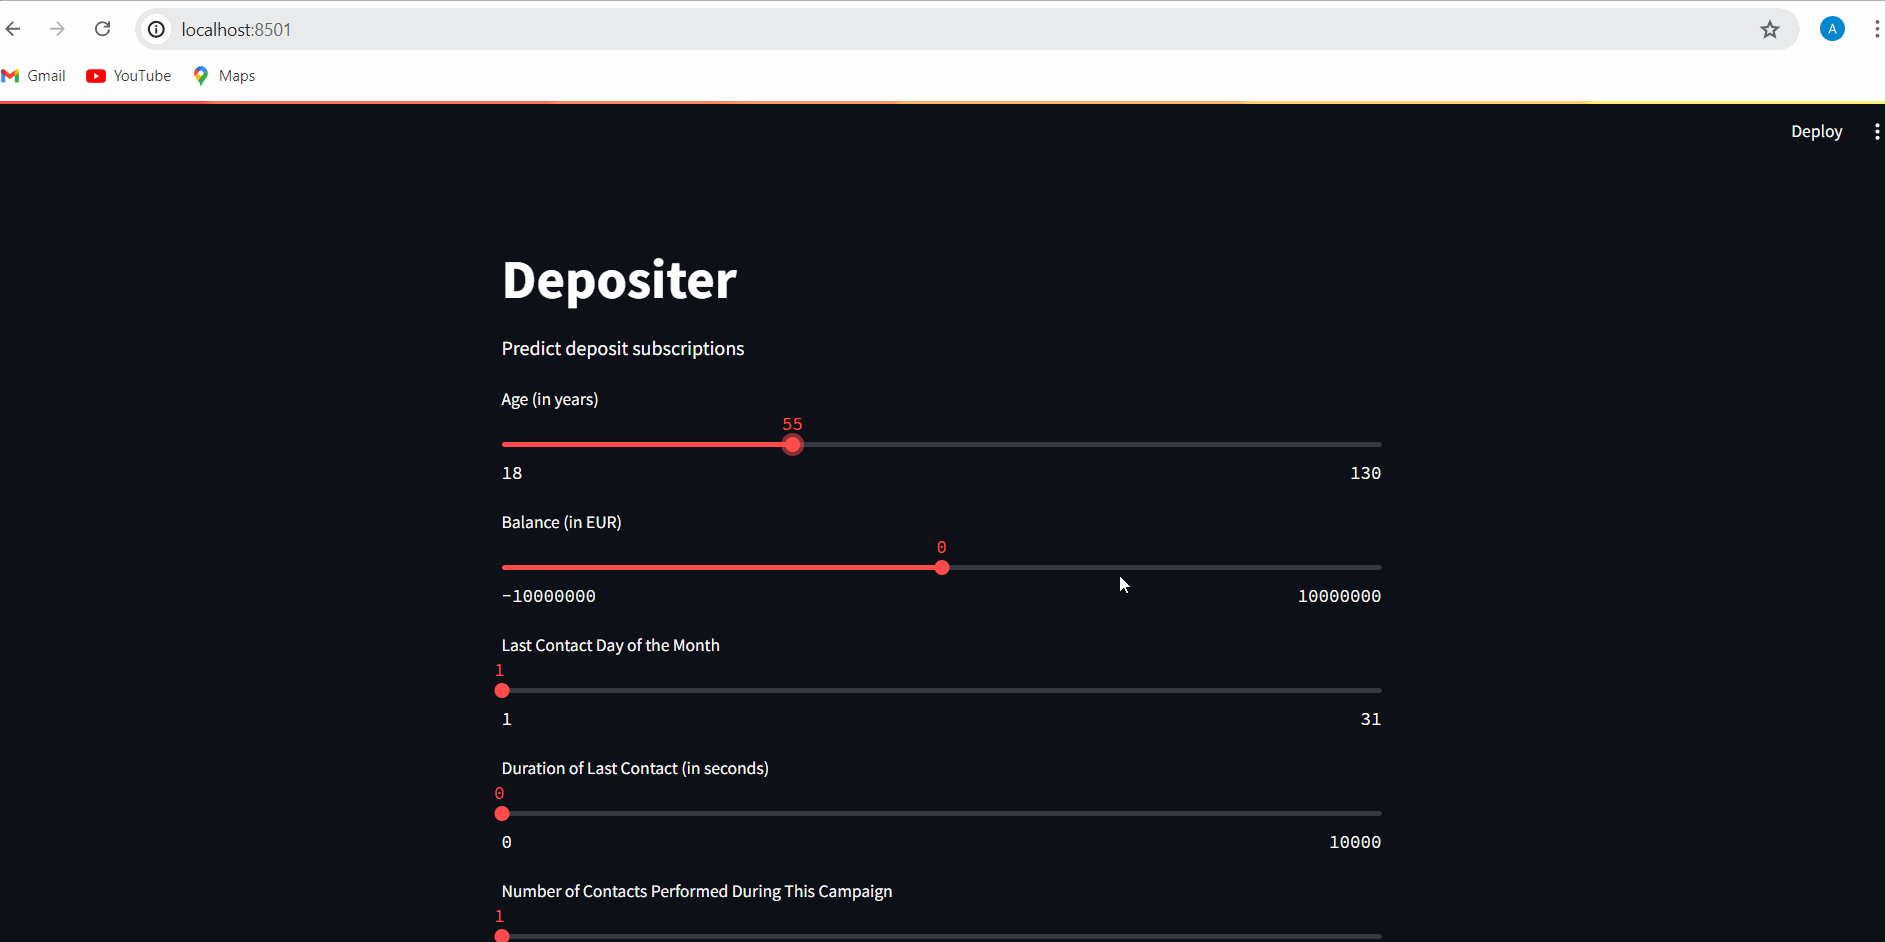

In [24]:
from IPython.display import Image, display
gif_path = 'C:/Users/Alexander_Kalita/Desktop/My_Projects/2_Portuguese_bank/2_MLOps/depositer_staging.gif'
display(Image(filename=gif_path))

# Concluding Remarks

The project concludes with the following issues:

**Data**. The current project utilizes an open-source dataset from a Portuguese bank, specifically designed for predicting customer deposit subscriptions. While this dataset serves as a valuable resource, it has limitations in terms of size and collection period. Finding similar datasets suitable for ML projects can be challenging. To address this issue, there is an intriguing solution involving synthetic data generation. By generating synthetic data that mirrors the properties of the real dataset, it can expand the dataset size and potentially enhance prediction accuracy. This approach offers a promising avenue for experimentation in future iterations of the project [5].

**Algorithm**. While the XGBoost model served as a state-of-the-art decision tree ensemble algorithm for handling tabular data in the project, its performance falls short compared to deep learning models with supervised self-learning capabilities, particularly when applied to audio, video, and text data. The urgent demand for a deep learning algorithm tailored to the specific heterogeneity of tabular data remains unmet. Unfortunately, research efforts aimed at combining the strengths of deep learning models with decision tree ensembles have stagnated [6].

**Business outcome**. Deposit marketers have traditionally struggled with navigating extensive customer lists, often resulting in inefficient allocation of marketing budgets to reach the desired target customer group. The ML model integrated into the Depositer application addresses this critical challenge in deposit marketing by accurately identifying the target audience of potential deposit subscribers for telemarketing campaigns.

# References

1. Kalita A. Predicting telemarketing success in the banking sector: the case of Portuguese bank. URL: https://github.com/Alexander-Kalita/Portuguese-bank-Case-study [accessed date: 15.03.2024].
2. Mohandas G. Machine Learning Canvas. URL: https://madewithml.com/courses/mlops/product-design/ [accessed date: 23.03.2024].
3. Bank Marketing Data. UCI Machine Learning Repository. URL: https://archive.ics.uci.edu/dataset/222/bank+marketing [accessed date: 23.03.2024].
4. Messalas A. (2020). Fairness, Accountability & Transparency (F.Acc.T) under GDPR. URL: https://code4thought.eu/2020/11/09/fairness-accountability-ty-transparency-f-acc-t-under-gdpr/ [accessed date: 15.03.2024].
5. Jordon J., Szpruch L., Houssiau F., Bottarelli M., Cherubin G., Maple C., Cohen S.N., Weller A. (2022). Synthetic Data - What, Why and How? The Alan Turing Institute, The Royal Society. URL: https://arxiv.org/abs/2205.03257 [accessed date: 13.04.2024].
6. Borisov V., Leemann T., Seßler K., Haug J., Pawelczyk M., Kasneci G. (2022). Deep Neural Networks and Tabular Data: A Survey. IEEE Transactions on Neural Networks and Learning Systems. URL: https://arxiv.org/abs/2110.01889 [accessed date: 15.03.2024].